# Cognition & Computation Project
## Manoj Kumar Nagabandi -> 2039097

The Dataset that i worked is on EMNIST Balanced which contains 131,600 characters with 47 balanced classes. 
It has a set of characters with an equal number of samples per class.

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

In [95]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
from tqdm.notebook import tqdm
import torch.nn.functional as functional
import torch
import torchvision as tv

from DBN import DBN

Let's choose dynamically the kind of device used for computations (CPU or GPU).

In [4]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


Then, let's download the EMNIST dataset. We download both the train and test datasets (we will use the test dataset later on).

In [5]:
%%capture
emnist_train = tv.datasets.EMNIST('data/',split='balanced', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

emnist_test = tv.datasets.EMNIST("data/",split='balanced',
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [6]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

The number shown is the number: 42


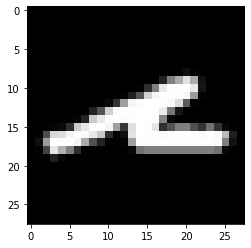

In [7]:
idx = 5
img = emnist_train.data[idx]
print("The number shown is the number: {}".format(emnist_train.targets[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

In [8]:
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

## Training a DBN

- The below code creates a Deep Belief Network (DBN) for the EMNIST dataset. 
- The DBN has 28x28 visible units, which represent the 28x28 pixel size of the images in the EMNIST dataset, and three hidden layers with 400, 700, and 1000 units. 
- The network is trained using contrastive divergence with k=1 and a learning rate of 0.1. 
- The momentum starts at 0.5 and increases to 0.9 over time, and the weight decay is set to 0.0001. 
- The computations are performed on a GPU. 
- The network does not use Xavier initialization.

We now create a hierarchical generative model (Deep Belief Network) and train it in an unsupervised way on the MNIST dataset.

In [11]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[400, 700, 1000],
                k=3,# contrastive divergence we can try increasing it to 2 or 3 to increse clarity of model
                learning_rate=0.001,#may be use wiser learning rate schedule instead of using constanting learning rate keeping learning decay as true may increase performance 
                learning_rate_decay=False,
                initial_momentum=0.5,# optimized already
                final_momentum=0.95,# optimized already
                weight_decay=0.0001,# optimized already
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [12]:
num_epochs = 100
batch_size = 125

dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |3.5054     |0.1359       |6.7854   |0.1856     |
|20    |2.8321     |0.0961       |6.2441   |0.1681     |
|30    |2.6458     |0.0889       |6.1870   |0.1857     |
|40    |2.5457     |0.0856       |6.0552   |0.1717     |
|50    |2.4819     |0.0816       |5.9909   |0.1549     |
|60    |2.4337     |0.0781       |5.9391   |0.1602     |
|70    |2.3960     |0.0778       |5.9519   |0.1660     |
|80    |2.3677     |0.0746       |6.0072   |0.1631     |
|90    |2.3433     |0.0712       |5.9495   |0.1841     |
|100    |2.3236     |0.0731       |5.9072   |0.1631     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |6.4768     |0.1575       |9.7140   |0.3174     |
|20    |5.1118     |0.1153       |8.3925   |0.2920     |
|30    |4.4752     |0.1102       |7.8017   |0.2255     |
|40    |4.1469     |0.1015       |7.4394   |0.2288     |
|

Summary of code written above:

- The code written above trains the DBN on the EMNIST dataset.
- The training is done in 3 layers, where each layer contains an RBM with different hiddden units 
-The number of training epochs is set to 100 and the batch size is 125.

Explanation of Results:
- In each training phase, the DBN is trained on the EMNIST dataset by utilizing the designated number of epochs and batch size. 
- The results indicate the mean reconstruction error, the standard deviation of re-construction error, the average gradient, and the standard deviation of the gradient for every hidden layer at each epoch. 
- The reconstruction error and gradients are indicators of the network's ability to reconstruct the input data, and these values typically decline as training continues.

- During the training of the RBM layer 1, the reconstruction error begins at 3.5054 with a standard deviation of 0.1359 and decreases to 2.3236 with a standard deviation of 0.0731 by the end of the training. 
- The mean gradient starts at 6.7854 with a standard deviation of 0.1856 and also decreases to 5.9072 with a standard deviation of 0.1631. A similar trend can be seen for the remaining two hidden layers.

## Visualizing receptive fields

- Having trained the network, we now aim to visualize the learned weights. To accomplish this, we will display a portion of the weights in the form of an image with the same dimensions as the EMNIST images utilized during training. Through this approach, we can observe the portions of an image that activate the unit linked with a particular weight vector

- Additionally, setting a threshold on the learned weights can help reduce the noise in the plots. Moreover, since the values in various weights can have varying ranges, we will utilize MinMaxScaler from Scikit-Learn to allow for a relevant comparison between the visualizations of various receptive fields.

In [13]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

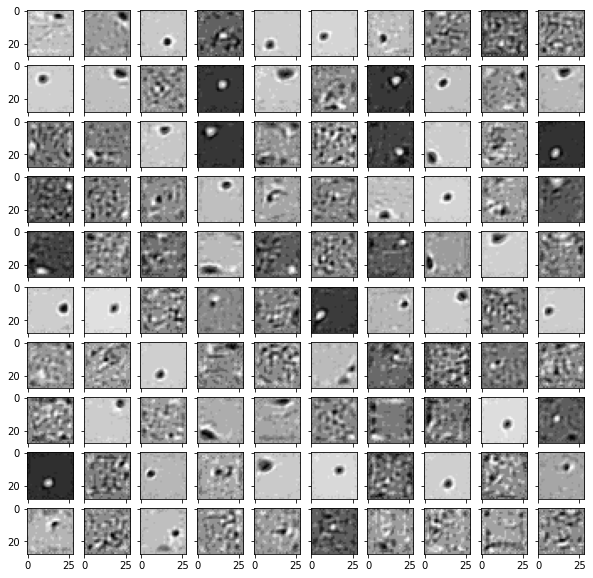

In [14]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

The weights in the second and third hidden layers have don't have the same dimensionality as EMNIST digits, therefore, we will need to project each of the vectors in a space of dimensionality `784` (`28`x`28`) in order to visualize them as images.

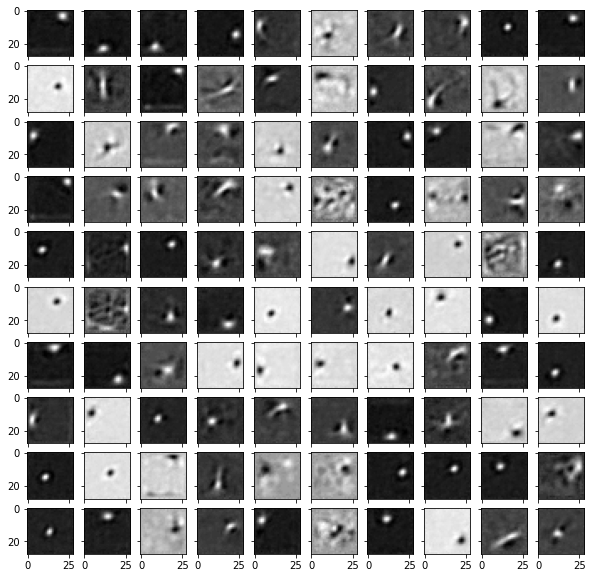

In [15]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

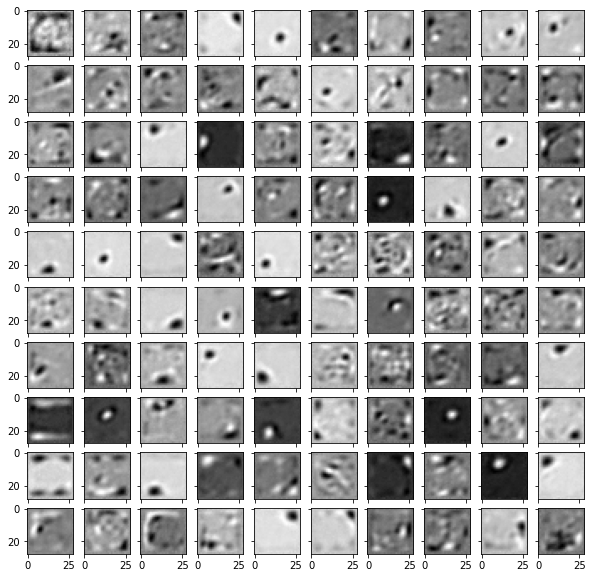

In [16]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

## Clustering internal representations

Next, we aim to study the characteristics of the learned representations. To do so, we will calculate the centroid of the representations learned for each class, and assess their proximity to each other by employing a standard hierarchical clustering algorithm.

The implementation of the DBN comprises multiple RBM objects internally, therefore, we must compute the hidden representation by utilizing the weights of each RBM included within the DBN.

In [17]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

The function "get_kth_layer_repr" is defined in this code and requires three inputs:

- "input": a tensor that represents the input data.
- "k": an integer indicating the desired hidden layer index.
- "device": the device (either CPU or GPU) on which the computation should occur.
- The function begins by transforming the input tensor into a 2D shape, where the first dimension is input.shape[0] and the second dimension is the number of visible units. This step is necessary as the RBM layers in the DBN expect a 2D input.

In [18]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

The above step involves invoking the "to_hidden" method of the kth RBM layer within the list of RBM layers in the DBN, providing the flattened input as input. The hidden representation of the input obtained from this method is then returned as the result of the function

Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

In [19]:
def get_mask(label):  # we use this function to filter by class
  labels = emnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [21]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

Now we can run the clustering algorithm and visualize it output in a dendrogram plot.

In [20]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

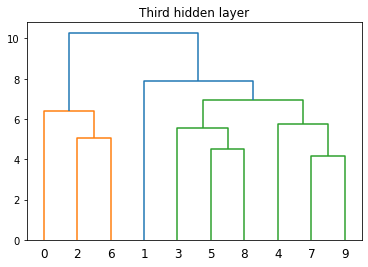

In [22]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

## Readout classifiers 

We can now extract the hidden representations of the data, by propagating the neuron's activations from the sensory (visible) layer in a bottom-up fashion, and try to lineary decode the content of the representations in a supervised way.

In [23]:
#class LinearModel(torch.nn.Module):
 # def __init__(self, last_layer_size):
    #super().__init__()
    #self.linear = torch.nn.Linear(last_layer_size, 47) # single layer classifier without any hidden layers which is a linear classifier to map the hidden 
    #representations at diff. levels of hierachy into supervised classes.Can be told as How good is 1st hidden layer to this entangled info of mnist digts 
    # to classify therm into 10 classes.
  #def forward(self, x):
   # return self.linear(x)
   
class LinearModel(torch.nn.Module):
    def __init__(self, last_layer_size, hidden_size=200):
        super().__init__()
        self.fc1 = torch.nn.Linear(last_layer_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, 47)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.linear(x)

- The above code uses class named "LinearModel".
- The class constructor takes two parameters: "last_layer_size" and "hidden_size" with a default value of 200. 
- The class inherits from the PyTorch "Module" class and has three fully connected layers: "fc1", "fc2", and "linear". 
- The activation function used is ReLU. 

Then,
- The "forward" method takes an input tensor "x" and passes it through the three fully connected layers. 
- The intermediate outputs are stored in the "x" tensor after applying ReLU activation on each of the outputs of "fc1" and "fc2" layers. 
- The final output of the "forward" method is the result of passing "x" through the "linear" layer.

In [24]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

- This code defines three objects of the "LinearModel" class, one for each hidden layer in the DBN.
-  It first retrieves the size of the representation of the first RBM layer by accessing the shape of the layer's weights, stored in the "layer_size" variable. 
- It then creates an instance of the "LinearModel" class and passes "layer_size" as an argument, storing the instance in the "linear1" variable and sending it to the designated device.

In [25]:
def train(network, input, epochs=5000, early_stopping=False):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  best_loss = float("inf")
  best_weights = None
  patience = 10
  count_since_best = 0

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

    if early_stopping:
      # Track the best loss and store the model parameters if it's the best
      if loss < best_loss:
        count_since_best = 0
        best_loss = loss
        best_weights = network.state_dict()
      else:
        count_since_best += 1

      if count_since_best >= patience:
        network.load_state_dict(best_weights)
        print("Early stopping triggered. Best loss: {:.4f}".format(best_loss))
        break

- The above code trains a neural network using the stochastic gradient descent optimizer, cross entropy loss function and early stopping (optional).
- The best loss and weights are tracked, and if the count since the last best loss exceeds a set patience, early stopping is triggered and the network is loaded with the best weights. 
- The training progress is printed every 100 epochs for 5000 Epochs

In [26]:
train(linear1, hidden_repr_layer_1)
train(linear2, hidden_repr_layer_2)
train(linear3, hidden_repr_layer_3)

epoch :   1/5000, loss = 3.8500
epoch : 101/5000, loss = 3.7319
epoch : 201/5000, loss = 3.2913
epoch : 301/5000, loss = 2.5543
epoch : 401/5000, loss = 1.9405
epoch : 501/5000, loss = 1.6192
epoch : 601/5000, loss = 1.4519
epoch : 701/5000, loss = 1.3533
epoch : 801/5000, loss = 1.2864
epoch : 901/5000, loss = 1.2355
epoch : 1001/5000, loss = 1.1940
epoch : 1101/5000, loss = 1.1588
epoch : 1201/5000, loss = 1.1283
epoch : 1301/5000, loss = 1.1012
epoch : 1401/5000, loss = 1.0767
epoch : 1501/5000, loss = 1.0543
epoch : 1601/5000, loss = 1.0335
epoch : 1701/5000, loss = 1.0140
epoch : 1801/5000, loss = 0.9957
epoch : 1901/5000, loss = 0.9783
epoch : 2001/5000, loss = 0.9619
epoch : 2101/5000, loss = 0.9463
epoch : 2201/5000, loss = 0.9314
epoch : 2301/5000, loss = 0.9170
epoch : 2401/5000, loss = 0.9032
epoch : 2501/5000, loss = 0.8898
epoch : 2601/5000, loss = 0.8769
epoch : 2701/5000, loss = 0.8645
epoch : 2801/5000, loss = 0.8524
epoch : 2901/5000, loss = 0.8406
epoch : 3001/5000, l

The above code used for training three linear models, linear1, linear2, and linear3, using the hidden representations of the first, second, and third layers of a pre-trained model, respectively.

In [27]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

This code stores the hidden representations of the test data at different layers in the DBN,using "hidden_repr_layer_1_test", "hidden_repr_layer_2_test" and "hidden_repr_layer_3_test" variables.

In [28]:
# here we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

The linear models are applied to the hidden representations of the test data and stores the predictions.

In [29]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

- The above function "predictions_test" (a tensor of predictions) and "targets" (a tensor of true labels for the test data). 
- The function converts the predictions to class indices, compares them to the true labels, and returns the average of correct predictions as the accuracy

In [30]:
compute_accuracy(predictions_test1, emnist_test.targets)

0.78367018699646

In [31]:
compute_accuracy(predictions_test2, emnist_test.targets)

0.8048403859138489

In [32]:
compute_accuracy(predictions_test3, emnist_test.targets)

#HW: Keep no of layers same for ex: 500,500,500 and see if tthe accuracy is still better like previous case scenario when layers increased.

0.8001595735549927

- The accuracy is increasing as we move higher in accuracy which makes sense, it suggests the neural network is building stronger and 
-  more robust represntations in hierachical generative model,the increase in accuracy it could also be due to increase in hidden units is more in 3rd layer compared to other 2 layers as we are projecting data into higher dimension space when compared to other 2 layers for example. 

## Comparison with a feed-forward model

Let's now train a simple feed-forward neural network with the same structure of the DBN, in order to compare a non-linear model that is trained end-to-end to solve a classification task with a simple linear classifier that solves the same task using representations of input data learned in an *unsupervised* way.

In [33]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size, hidden_size=200):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.fc1 = torch.nn.Linear(third_hidden_layer_size, hidden_size)
    self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
    self.linear = torch.nn.Linear(hidden_size, 47)
    self.relu = torch.nn.ReLU()

  def forward(self, input):
    first_hidden_repr = self.relu(self.first_hidden(input))
    second_hidden_repr = self.relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = self.relu(self.third_hidden(second_hidden_repr))
    hidden_repr = self.relu(self.fc1(third_hidden_repr))
    hidden_repr = self.relu(self.fc2(hidden_repr))
    output = self.linear(hidden_repr)
    return output

- The has a class with an init method that initializes 5 linear layers and one ReLU activation layer.
- The first three linear layers are for computing hidden representations of the input data, and the remaining two linear layers and the ReLU layer are for computing the final output. 
- The forward method takes an input tensor and passes it through the layers defined in the init method to compute the final output.

In [36]:
ffnn = Feedforward(400, 700, 1000).to(device)# ffnn called as feedforward neural network with same layers w.r.t to DBN to get fair comparision 

We choose the number of epochs to match the training time of the DBN and the readout layer combined.

In [37]:
train(ffnn, emnist_train.data.reshape((112800, 784)), epochs=5000)# takes more time than linear classifier since we are training entire linear model with 3 hidden layers using exact same funciton used for DBN
# we can count no of parameter weights similar to DBN model like 784*400+400*700+700*1000+1000*47 which is why it takes more time. 

epoch :   1/5000, loss = 3.8513
epoch : 101/5000, loss = 3.8505
epoch : 201/5000, loss = 3.8498
epoch : 301/5000, loss = 3.8492
epoch : 401/5000, loss = 3.8485
epoch : 501/5000, loss = 3.8477
epoch : 601/5000, loss = 3.8467
epoch : 701/5000, loss = 3.8454
epoch : 801/5000, loss = 3.8434
epoch : 901/5000, loss = 3.8405
epoch : 1001/5000, loss = 3.8357
epoch : 1101/5000, loss = 3.8258
epoch : 1201/5000, loss = 3.7988
epoch : 1301/5000, loss = 3.6692
epoch : 1401/5000, loss = 3.2490
epoch : 1501/5000, loss = 2.9336
epoch : 1601/5000, loss = 2.5830
epoch : 1701/5000, loss = 2.3068
epoch : 1801/5000, loss = 2.1727
epoch : 1901/5000, loss = 2.0112
epoch : 2001/5000, loss = 1.8567
epoch : 2101/5000, loss = 1.6601
epoch : 2201/5000, loss = 1.5674
epoch : 2301/5000, loss = 1.4192
epoch : 2401/5000, loss = 1.3016
epoch : 2501/5000, loss = 1.1632
epoch : 2601/5000, loss = 1.1065
epoch : 2701/5000, loss = 1.0419
epoch : 2801/5000, loss = 1.0027
epoch : 2901/5000, loss = 0.9398
epoch : 3001/5000, l

In [40]:
predictions_ffnn = ffnn(emnist_test.data.reshape((18800, 784)))

In [42]:
compute_accuracy(predictions_ffnn, emnist_test.targets)


0.77765953540802

- We can say DBN and Feedforward gives same accuracy if compared with performance metric. 
- However if we give noisy data how fast the performance drop can be characterised by stiochiometric terms.
- So we systematically test models using many levels of noise we can see how robust the model is with increase in pertubations with sensory data.

## Robustness to noise

We will now inject some noise in the input images and see how much the representations learned by the DBN and the feed-forward network are robust to perturbations in the sensory signal.

Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

In [43]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor
  # here check the sum if it is larger to 1 put it to 1 and if it is smaller than 0 put it to zero advanced version of 
  # noise function.

Let's see what a noisy image looks like:

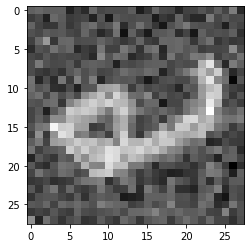

In [44]:
noise_level = 0.2
mnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")


We will now compute the hidden representations for the noisy images using the DBN. Then, we will use the read-out classifiers that we trained on the representations without noise to classify the noisy stimuli.

In [47]:
def get_accuracy_values_at_noise_level(noise_level):

  mnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy,emnist_test.targets)
  
  predictions_ffnn_noisy = ffnn(mnist_test_with_noise.reshape((18800, 784)))  # we repeat a similar process for the feed-forward model
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

The "get_accuracy_values_at_noise_level" function above takes a noise_level argument and evaluates the robustness of 4 models (DBN hidden layers and feedforward) by adding Gaussian noise to the test data, computing their representations, passing them to linear models, computing accuracy, and returning accuracy values.

In [50]:
acc = get_accuracy_values_at_noise_level(0.4);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

# we can see ffnn is crashinh whereas DBN layers like in 3 rd is almost constant

Accuracy of H1 read-out: 0.609
Accuracy of H2 read-out: 0.744
Accuracy of H3 read-out: 0.729
Accuracy of FF network : 0.614


- The above function "get_accuracy_values_at_noise_level" with noise level 0.4, storing the returned accuracy values for 4 models. 
- The accuracy values fell more than 10%  in Feedforward network compared to 2rd layer of DBN, indicating models are not robust to noise due to lack of training with noisy data and also tells DBN performs good if there is noise in the image compared to Feedforward Network.

Let's create the psychometric curves for the DBN (at different levels of internal representations) and for the feed-forward network:

In [51]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

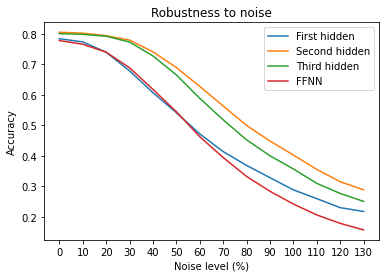

In [52]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

As we can see in the above graph intially when noise in low both models performed same but as noise in image started increasing accuracy to detecting correct label decreased drastically for feedforward network compared to DBN layers and Layer 2 performed better when compared.

## Perturbing the models with adversarial attacks

- Adversarial attacks modify inputs to make a model misclassify them by increasing the loss of the model.
- This loss is a function of input, model parameters, and outputs. 
- During training, the model's weights are adjusted based on the gradient of the loss in the opposite direction to minimize the loss. 
- Adversarial samples change the input instead of weights and use the gradient direction to increase the loss.
- The adversarial sample is obtained by adding a perturbation (ε) to the original input, scaled by the gradient of the loss with respect to the input.
$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [53]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

### Adversarial samples

In [67]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [78]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)

Let's see what an adversiarial sample looks like. Let't take one sample from the test set:

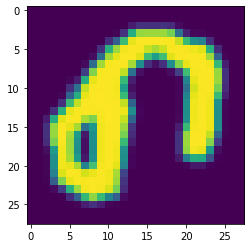

In [69]:
test_sample_idx = 1
test_image = emnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

Let's classify this "clean" image using one of the models we previously trained and then modify the image to attack the network.

To change the model we attack, you can modify the value of the `model` variable in the cell below (choosing between `ffnn` and `dbn_with_readout`).

In [86]:
attacked_model = ffnn

In [88]:
attacked_model = dbn_with_readout

In [81]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 39.


Let's create and visualize the corresponding adversarial sample. 
The function `loss.backward()` computes the gradient for every parameter that was activated using the call `requires_grad=True`.

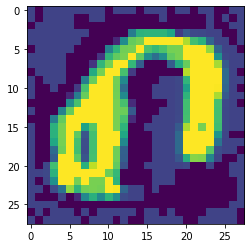

In [82]:
epsilon = 0.2  # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [89]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 26.


### Resisting to adversarial attacks

Let's now compare the ability to resist to adversarial attacks of our two models: the feedforward network and the DBN.

We will also test the ability of the DBN to reduce the impact of the attack by performing one "top-down" reconstruction step, from the hidden representation of the last layer to the visible units, and back to the hidden representation.

In [96]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [93]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('data/', train=False,split='balanced', download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

Let's see how good the FFNN does:

In [97]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/188 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 12.42%



In [98]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

  0%|          | 0/188 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 37.85%



And finally let's test whether using one step of top-down reconstruction from the generative model allows to improve resilience to attacks:

  0%|          | 0/188 [00:00<?, ?it/s]


Here's the original sample:



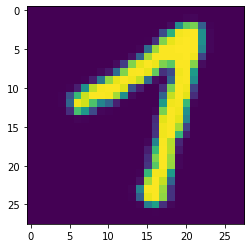


Here's a perturbed sample:



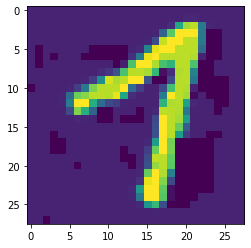


Here's what a 1-steps reconstructed sample looks like:



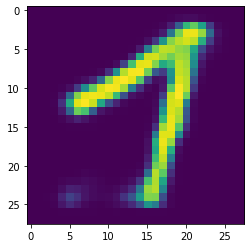


Epsilon: 0.1
Test Accuracy: 63.49%



In [99]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

Similarly for n_steps = 2

  0%|          | 0/188 [00:00<?, ?it/s]


Here's the original sample:



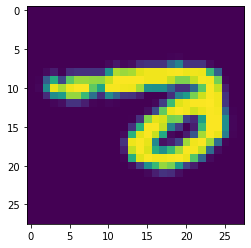


Here's a perturbed sample:



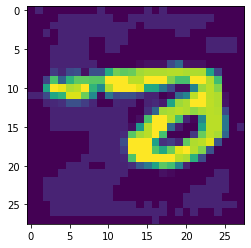


Here's what a 2-steps reconstructed sample looks like:



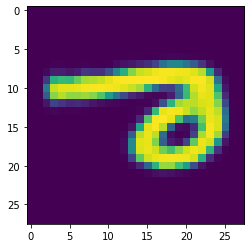


Epsilon: 0.1
Test Accuracy: 64.12%



In [103]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=2)

### Effect of the noise parameter $\epsilon$

Let's compare the robustness of each model to adversarial attacks of different "strengths":

In [104]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [105]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

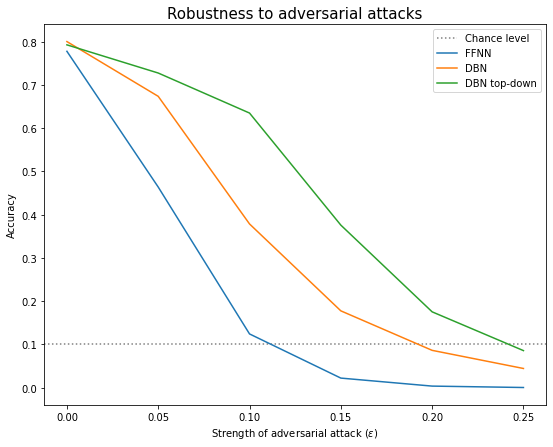

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

From the above plot we can see that DBN top-down has good accuracy when compared to DBN and FFNN as strength of Adversarial attacks increases.

I have tried different configurations as you suggested in the class and the summary is given below in form of a table


In [8]:
import pandas as pd

table_data = {
    'No. of Layers ': [3, 3, 3, 3, 3 ],
    'Layers': ['[400,500,800]', '[500,700,1000]','[500,500,500]', '[400,500,800]','[400,500,800]'],
    'Epochs DBN has trained on': [50, 100, 50, 50, 50],    
    'Layers used in Linear-readout': ['FC-1 [LLS 200], FC-2 [200 200],Linear [200 47],ReLU ', 'FC-1 [LLS 200], FC-2 [200 200],Linear [200 47],ReLU', 'FC-1 [LLS 200], FC-2 [200 200],Linear [200 47],ReLU','FC-1 [LLS 200],ReLU, FC-2 [200 47]', 'FC-1 [LLS 200], FC-2 [200 47],ReLU'],
    'Accuracy of First DBM layer ': [80.60,78.36,78.74,75.22,78.82],
    'Accuracy of Second DBM layer ': [81.02,80.48,79.66,75.88,79.46],
    'Accuracy of Third DBM layer ': [81.81,80.01,79.63,76.49,79.77],
    'Accuracy of Feed forward Network' : [81.04,77.7,80.48,80.71,79.95]
}

df = pd.DataFrame(table_data).set_index('Layers')
df


,No. of Layers,Epochs DBN has trained on,Layers used in Linear-readout,Accuracy of First DBM layer,Accuracy of Second DBM layer,Accuracy of Third DBM layer,Accuracy of Feed forward Network
Layers,,,,,,,
"[400,500,800]",3,50,"FC-1 [LLS 200], FC-2 [200 200],Linear [200 47]...",80.60,81.02,81.81,81.04
"[500,700,1000]",3,100,"FC-1 [LLS 200], FC-2 [200 200],Linear [200 47]...",78.36,80.48,80.01,77.70
"[500,500,500]",3,50,"FC-1 [LLS 200], FC-2 [200 200],Linear [200 47]...",78.74,79.66,79.63,80.48
"[400,500,800]",3,50,"FC-1 [LLS 200],ReLU, FC-2 [200 47]",75.22,75.88,76.49,80.71
"[400,500,800]",3,50,"FC-1 [LLS 200], FC-2 [200 47],ReLU",78.82,79.46,79.77,79.95


*The FC1,FC2 indicates Fully connected linear layers and LLS means last layer size of DBN layers. 

- We saw DBN with 400,500,800 as hidden layers and used layers (FC-1 [LLS 200], FC-2 [200 200],Linear [200 47]) in Linear-Readout with ReLU activation function gives best accuracy among all the differernt models trained. 
- We visualized output of 3rd layer of DBN using Dendogram and visualized how distant one label is different from other.
- We also saw that DBN is more resistant to noise compared to Feedforward Networks when we add noise.
- We also tried Adverserial attacks on both models and saw that DBN is more resistant to attacks compared to Feedforward Networks as strength of attack increases and was able to classify to label images better. 